In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from scipy.signal import tukey
from scipy.optimize import minimize

In [2]:
def build_fun(tmax, fmax, freqs, data, psds, trigtime, srate, seglen, bounds):
    def fun(x, t=tmax, f=fmax, data=data, psds=psds, trig=trigtime,seglen=seglen, srate=srate, bounds=bounds):
        for i, val in enumerate(x):
            min, max = bounds[i]
            if min < val < max:
                continue
            else:
                return np.inf
        A, p, Q = x
        asd = psds ** (1/2.)
        gl = build_FD_glitch(A, p, Q, t, f, asd, seglen, srate, trigtime=trig)
        return -logl(freqs, gl, data, psds)
    return fun

def logl(freqs, gl, d, psd, flow=10.):
    df = freqs[1]-freqs[0]
    sel = freqs > flow
    gg = np.sum(4.0*df*(gl.conj()[sel]*gl[sel]).real/psd[sel])
    gd = np.sum(4.0*df*(d.value.conj()[sel]*gl[sel]).real/psd[sel])
    logl = -0.5*(gg - 2.0*gd)
    return logl

def build_FD_glitch(A, p, Q, t, f, asd, seglen, srate, trigtime=None):
    dT = 1 / srate
    dF = 1 / seglen
    if ~(0 <= t < seglen) and trigtime is not None:
        t = trigtime-t+seglen-2
    Anorm = (2*seglen) / (srate ** 2.)
    Tobs = seglen
    fLow = 10.
    fHigh = srate/2.
    low = np.ceil(fLow / dF)
    high = np.floor(fHigh / dF)-1
    FD_glitch = np.zeros(int(srate*seglen/2)+1, dtype=np.complex)
    A = A*Anorm
    tau = Q/(2*np.pi) / f
    glitchLow = int(np.floor((f - 1. / tau) / dF))
    glitchHigh = int(np.ceil((f + 1 / tau) / dF))
    for i in range(glitchLow, glitchHigh):
        if i >= low and i <= high:
            amparg = (i * dF - f) * np.pi * tau
            phasearg = np.pi * i + p - 2 * np.pi * i * dF * (t-Tobs/2.)
            print(phasearg)
            Ai = A * tau * 0.5 * np.sqrt(np.pi) * np.exp(-amparg * amparg) *asd[i] / np.sqrt(Tobs)
            real = Ai * np.cos(phasearg)
            imag = Ai * np.sin(phasearg)

            FD_glitch[i] = real + 1j * imag
    return FD_glitch

def tukey_window(ts, seglen, a=0.4):
    window = tukey(len(ts), alpha=a/seglen)
    return ts*window

def time_sens_ifft(fs, data):
    nout = (fs.size - 1) * 2
    dift = np.fft.irfft(fs.value * nout) / 2
    new = TimeSeries(dift, epoch=fs.epoch, times=data.times)
    return new

In [3]:
seglen = 8.
srate = 1024.
trigtime = 1126103127.521729
L1_data_files = ['L-L1_HOFT_C01-112609686-4096.gwf', 'L-L1_HOFT_C01-1126100992-4096.gwf', 'L-L1_HOFT_C01-1126105088-4096.gwf']
L1_channel = 'L1:DCS-CALIB_STRAIN_C01'
L1_psd_file = '1126103127.522_L1-PSD.dat'
start = trigtime-seglen+2
end = trigtime+2
L1_ts = TimeSeries.read(L1_data_files, L1_channel, start=start, end=end)
L1_qtranf = L1_ts.q_transform()
t_max_idx, f_max_idx = np.unravel_index(np.argmax(L1_qtranf), L1_qtranf.shape)
L1_fs = tukey_window(L1_ts.resample(1024.), seglen).fft()
t_max = L1_qtranf.times[t_max_idx].value
f_max = L1_qtranf.frequencies[f_max_idx].value

In [9]:
dT = 1 / srate;
n = srate*seglen
Anorm = np.sqrt(2*dT/n)
#np.random.seed(10)
Amin, Amax = 10./Anorm, 1000./Anorm
print(Amin, Amax)

(20480.0, 2048000.0)


In [ ]:
Anorm = (2*seglen) / (srate ** 2.)
#np.random.seed(10)
Amin, Amax = 10/Anorm, 1000/Anorm
phiMin, phiMax = 0, 2*np.pi
Qmin, Qmax = 3, 30
Amp0 = Amin+(Amax-Amin)*np.random.rand()
phi0 = phiMin+(phiMax-phiMin)*np.random.rand()
Q0 = Qmin+(Qmax-Qmin)*np.random.rand()
tmp = np.genfromtxt(L1_psd_file)
L1_freqs, L1_psd = tmp[:,0], tmp[:,1]
x0 = (Amp0, phi0, Q0)
bounds=((Amin, Amax), (phiMin, phiMax), (Qmin, Qmax))
logl_func = build_fun(t_max, f_max, L1_freqs, L1_fs, L1_psd, trigtime, srate, seglen, bounds)
sol = minimize(logl_func, x0, options={'disp': True, 'maxiter': 20}, method='powell')
FD = build_FD_glitch(sol.x[0], sol.x[1],sol.x[2], t_max, f_max, L1_psd**(1/2.),seglen, srate,trigtime=trigtime)
glitch_fs = FrequencySeries(data = FD, frequencies=L1_fs.frequencies.value)
glitch_ts = time_sens_ifft(glitch_fs, L1_ts.resample(1024))

808.2597490641127
809.8305450164006
811.4013409686885
812.9721369209764
814.5429328732642
816.113728825552
817.68452477784
819.2553207301278
820.8261166824157
822.3969126347035
823.9677085869914
825.5385045392792
827.1093004915672
828.6800964438551
830.2508923961428
831.8216883484308
833.3924843007186
834.9632802530065
836.5340762052944
838.1048721575822
839.67566810987
841.246464062158
842.8172600144458
844.3880559667336
845.9588519190216
847.5296478713094
849.1004438235973
850.6712397758852
852.242035728173
853.8128316804609
855.3836276327488
856.9544235850366
858.5252195373246
860.0960154896125
861.6668114419002
863.2376073941882
864.808403346476
866.3791992987639
867.9499952510517
869.5207912033396
871.0915871556274
872.6623831079154
874.2331790602032
875.803975012491
877.374770964779
878.9455669170668
880.5163628693547
882.0871588216426
883.6579547739304
885.2287507262182
886.7995466785062
888.370342630794
889.9411385830819
891.5119345353697
893.0827304876576
894.6535264399455
896

/home/bedelman/.local/lib/python2.7/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom



856.8599475147685
858.4307434670562
860.0015394193442
861.572335371632
863.1431313239199
864.7139272762078
866.2847232284956
867.8555191807834
869.4263151330714
870.9971110853592
872.567907037647
874.138702989935
875.7094989422228
877.2802948945107
878.8510908467986
880.4218867990865
881.9926827513742
883.5634787036622
885.13427465595
886.7050706082379
888.2758665605257
889.8466625128136
891.4174584651015
892.9882544173894
894.5590503696773
896.129846321965
897.700642274253
899.2714382265408
900.8422341788287
902.4130301311166
903.9838260834044
905.5546220356922
907.1254179879802
908.6962139402681
910.2670098925558
911.8378058448438
913.4086017971316
914.9793977494196
916.5501937017074
918.1209896539953
919.6917856062831
921.262581558571
922.8333775108588
924.4041734631468
925.9749694154347
927.5457653677224
929.1165613200104
930.6873572722982
932.2581532245861
933.828949176874
935.3997451291618
936.9705410814496
938.5413370337376
940.1121329860254
941.6829289383132
943.2537248906012


/home/bedelman/.local/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/bedelman/.local/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/bedelman/.local/lib/python2.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)



136.39781445629433
137.9686104085822
139.53940636087006
141.1102023131579
142.68099826544582
144.25179421773367
145.82259017002153
147.3933861223094
148.96418207459726
150.53497802688514
152.10577397917302
153.67656993146088
155.24736588374876
156.8181618360366
158.3889577883245
159.95975374061237
161.53054969290022
163.10134564518808
164.67214159747596
166.24293754976384
167.81373350205172
169.38452945433957
170.95532540662742
172.5261213589153
174.09691731120316
175.66771326349104
177.23850921577892
178.80930516806677
180.38010112035462
181.9508970726425
183.52169302493039
185.09248897721827
186.66328492950612
188.23408088179397
189.80487683408185
191.3756727863697
192.9464687386576
194.51726469094547
196.08806064323332
197.65885659552117
199.22965254780905
200.80044850009693
202.37124445238481
203.94204040467267
205.51283635696052
207.0836323092484
208.65442826153628
210.22522421382413
211.79602016611202
213.36681611839987
214.93761207068775
216.50840802297563
218.07920397526348
21

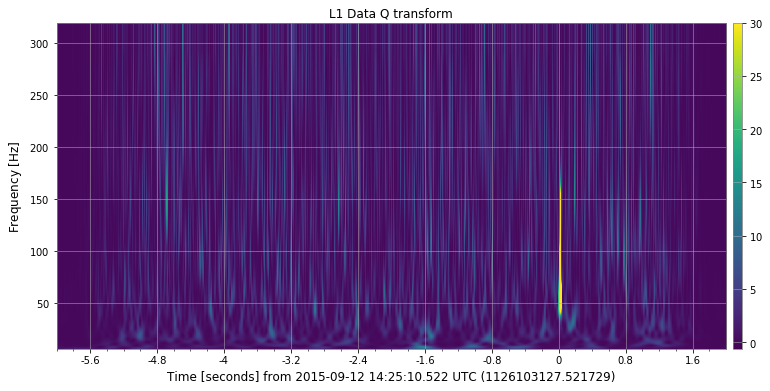

In [5]:
data_Q = 5.5
plt_ts = L1_ts.resample(1024).copy()
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1 Data Q transform')
ax.colorbar()
data_Q = q_Tr.q

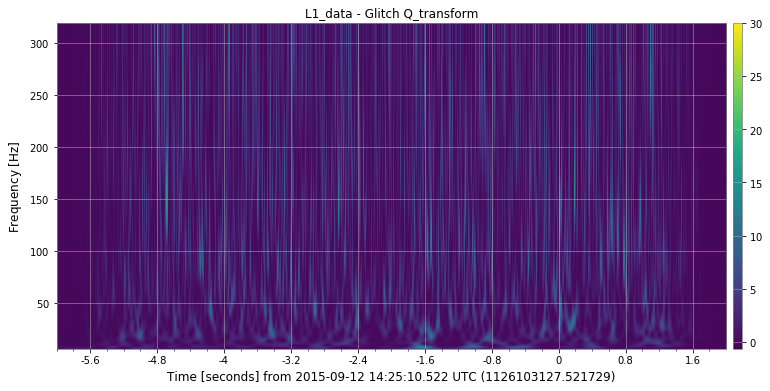

In [6]:
plt_ts = L1_ts.resample(1024).copy()
plt_ts -= glitch_ts
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1_data - Glitch Q_transform')
ax.colorbar()

In [7]:
L1_ts = plt_ts
L1_qtranf = L1_ts.q_transform()
t_max_idx, f_max_idx = np.unravel_index(np.argmax(L1_qtranf), L1_qtranf.shape)
L1_fs = tukey_window(L1_ts, seglen).fft()
t_max = L1_qtranf.times[t_max_idx].value
f_max = L1_qtranf.frequencies[f_max_idx].value
print(t_max, f_max)

(1126103127.5217285, 180.51580810546875)


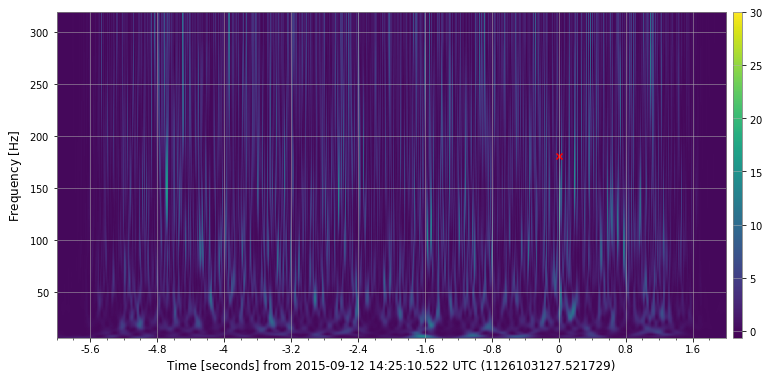

In [8]:
q_Tr = L1_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.colorbar()
ax.set_epoch(trigtime)
ax.scatter(t_max, f_max, color='r', marker='x')


In [10]:
Amp0 = Amin+(Amax-Amin)*np.random.rand()
phi0 = phiMin+(phiMax-phiMin)*np.random.rand()
Q0 = Qmin+(Qmax-Qmin)*np.random.rand()
x0 = (Amp0, phi0, Q0)
logl_func = build_fun(t_max, f_max, L1_freqs, L1_fs, L1_psd, trigtime, srate, seglen, bounds)
sol = minimize(logl_func, x0, options={'disp': True, 'maxiter': 20}, method='powell')
print(sol.x, t_max, f_max)
FD = build_FD_glitch(sol.x[0], sol.x[1],sol.x[2], t_max, f_max, L1_psd**(1/2.),seglen, srate,trigtime=trigtime)
glitch2_fs = FrequencySeries(data = FD, frequencies=L1_fs.frequencies.value)
glitch2_ts = time_sens_ifft(glitch2_fs, L1_ts)

Optimization terminated successfully.
         Current function value: -1.337542
         Iterations: 5
         Function evaluations: 193
(array([4.01047534e+06, 1.49609858e+00, 5.17104427e+00]), 1126103127.5217285, 180.51580810546875)


In [11]:
print(max(glitch2_ts.value))

7.800092135128727e-22


In [37]:
def plot_glitch_add_noise(ts, oldmaxt, oldmaxf, seglen, trigtime, Q=11.5):
    glitch = ts.copy()
    noise = TimeSeries(np.random.randn(len(glitch))*0.01*max(glitch.value), times=glitch.times)
    glitch += noise
    qtr = glitch.q_transform(qrange=(Q, Q), whiten=False, fres=1/seglen)
    print(qtr.q)
    pl = qtr.plot()
    ax = pl.gca()
    ax.colorbar()
    ax.set_epoch(trigtime)
    newmaxt, newmaxf = np.unravel_index(np.argmax(qtr), qtr.shape)
    newmaxt = qtr.times[newmaxt]
    newmaxf = qtr.frequencies[newmaxf]
    ax.scatter(oldmaxt, oldmaxf, marker='x', color='r', label='old')
    ax.scatter(newmaxt, newmaxf, marker='x', color='darkorange', label='new')
    ax.legend()

11.5


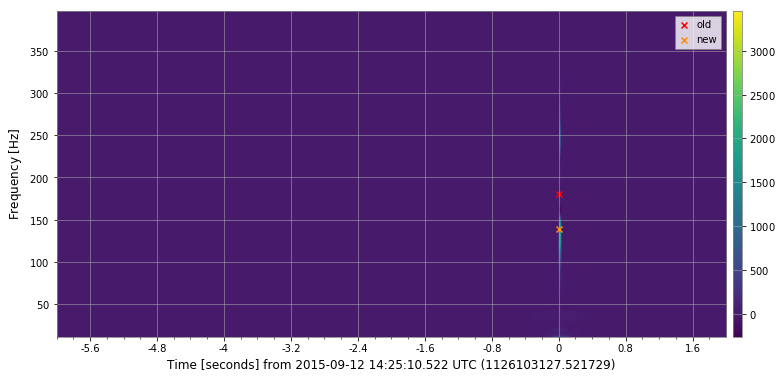

In [38]:
plot_glitch_add_noise(glitch2_ts, t_max, f_max, seglen, trigtime)

/home/bedelman/.local/lib/python2.7/site-packages/gwpy/timeseries/timeseries.py:948: UserWarning: resample() rate matches current sample_rate (1024.0 Hz), returning input data unmodified; please double-check your parameters
  UserWarning,


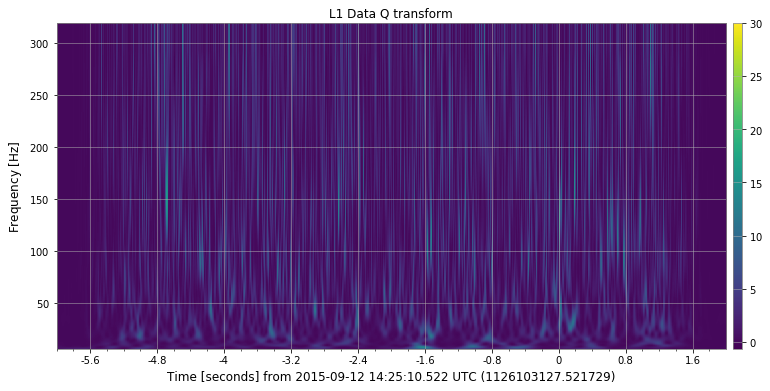

In [39]:
data_Q = 5.5
plt_ts = L1_ts.resample(1024).copy()
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1 Data Q transform')
ax.colorbar()
data_Q = q_Tr.q

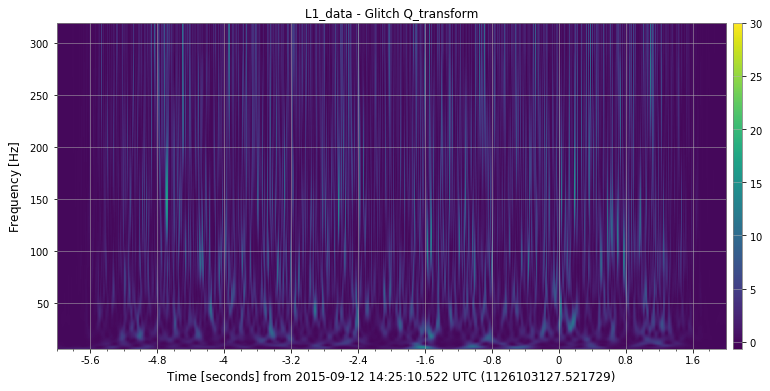

In [40]:
plt_ts = L1_ts.resample(1024).copy()
plt_ts -= glitch2_ts
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1_data - Glitch Q_transform')
ax.colorbar()